In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [339]:
file_path = 'ds/DECADQ_74_previous-1950-2022.csv'
data = pd.read_csv(file_path, delimiter=";")

In [340]:
data.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
0,74001001,ABONDANCE,46.2845,6.734167,947,195001,1,78.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,74001001,ABONDANCE,46.2845,6.734167,947,195001,2,24.8,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,74001001,ABONDANCE,46.2845,6.734167,947,195001,3,18.6,9.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,74001001,ABONDANCE,46.2845,6.734167,947,195002,1,83.1,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,74001001,ABONDANCE,46.2845,6.734167,947,195002,2,56.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [341]:
data.describe()

,NUM_POSTE,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,RRAB,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
count,1.315210e+05,131521.000000,131521.000000,131521.000000,131521.000000,131521.000000,126731.000000,126731.000000,131511.000000,126731.000000,...,58070.000000,58070.000000,58070.000000,23946.000000,58129.000000,58129.000000,58129.000000,131511.000000,28550.000000,25922.000000
mean,7.415114e+07,46.042651,6.463336,848.726941,198927.798587,2.000783,38.182292,1.475953,9.695600,17.729551,...,3.835354,20.568538,3.637661,15.257872,2.881660,2.311669,1.551618,1.754751,0.769247,0.695201
std,1.034983e+05,0.167798,0.290198,456.104228,2143.370664,0.816389,35.969416,1.891714,2.071162,14.578754,...,3.826713,44.622368,3.760872,8.911750,4.162301,3.965041,3.440570,3.821451,1.129559,1.298074
min,7.400100e+07,45.713000,5.841667,309.000000,195001.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.405642e+07,45.901667,6.255333,470.000000,197008.000000,1.000000,10.500000,1.000000,10.000000,6.600000,...,1.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.413600e+07,46.013000,6.483333,785.000000,199309.000000,2.000000,29.400000,1.000000,10.000000,15.000000,...,1.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.423600e+07,46.168333,6.692833,1080.000000,200803.000000,3.000000,55.400000,1.000000,10.000000,25.400000,...,9.000000,18.000000,9.000000,22.000000,7.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,7.450000e+07,46.396500,6.970833,3845.000000,202212.000000,3.000000,407.300000,9.000000,11.000000,180.000000,...,9.000000,440.000000,9.000000,31.000000,11.000000,11.000000,11.000000,11.000000,8.000000,11.000000


In [342]:
data = data.drop(data[(data["AAAAMM"] >= 195001) & (data["AAAAMM"] <= 197912)].index)

In [343]:
# Fonction pour formater les dates AAAAMM en AAAA-MM-01
def format_date(aaaamm):
    return re.sub(r'(\d{4})(\d{2})', r'\1-\2-01', str(aaaamm))

# Liste des dates formatées
data["AAAAMM"] = [format_date(val) for val in data["AAAAMM"]]
data.rename(columns={"AAAAMM": "date"}, inplace=True)

In [344]:
aggregated_data = data.groupby("date").agg({
    'RR': 'sum',
    'QRR': 'sum',
    'NBRR': 'sum',          
    'NBJRR10': 'mean',    
    'NBJRR5': 'mean',     
    'NBJRR1': 'mean'      
})

aggregated_df = pd.DataFrame(aggregated_data)

print(aggregated_df)
#aggregated_df.to_csv("precipitation.csv")

                 RR    QRR    NBRR   NBJRR10    NBJRR5    NBJRR1
date                                                            
1980-01-01   6175.1  141.0  1209.0  1.940171  2.529915  4.111111
1980-02-01   4664.2  141.0  1131.0  1.324786  2.068376  3.324786
1980-03-01   5865.5  141.0  1209.0  2.153846  3.119658  5.145299
1980-04-01   1205.4  129.0  1129.0  0.176991  0.752212  2.469027
1980-05-01   4992.0  114.0  1178.0  1.719298  2.798246  4.438596
...             ...    ...     ...       ...       ...       ...
2022-08-01   3529.4  139.0  1431.0  0.956835  1.553957  2.424460
2022-09-01   7712.3  156.0  1382.0  1.757143  3.228571  5.092857
2022-10-01   6078.7  149.0  1434.0  1.375887  1.893617  3.063830
2022-11-01   6420.3  143.0  1389.0  1.734266  2.349650  4.489510
2022-12-01  10161.3  191.0  1627.0  2.143713  3.131737  4.604790

[516 rows x 6 columns]


In [345]:
aggregated_df = aggregated_df.reset_index()
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
print(aggregated_df)

          date       RR    QRR    NBRR   NBJRR10    NBJRR5    NBJRR1
0   1980-01-01   6175.1  141.0  1209.0  1.940171  2.529915  4.111111
1   1980-02-01   4664.2  141.0  1131.0  1.324786  2.068376  3.324786
2   1980-03-01   5865.5  141.0  1209.0  2.153846  3.119658  5.145299
3   1980-04-01   1205.4  129.0  1129.0  0.176991  0.752212  2.469027
4   1980-05-01   4992.0  114.0  1178.0  1.719298  2.798246  4.438596
..         ...      ...    ...     ...       ...       ...       ...
511 2022-08-01   3529.4  139.0  1431.0  0.956835  1.553957  2.424460
512 2022-09-01   7712.3  156.0  1382.0  1.757143  3.228571  5.092857
513 2022-10-01   6078.7  149.0  1434.0  1.375887  1.893617  3.063830
514 2022-11-01   6420.3  143.0  1389.0  1.734266  2.349650  4.489510
515 2022-12-01  10161.3  191.0  1627.0  2.143713  3.131737  4.604790

[516 rows x 7 columns]


In [346]:
multiplicative_decomposition = seasonal_decompose(aggregated_df['RR'], model='multiplicative', period=12)

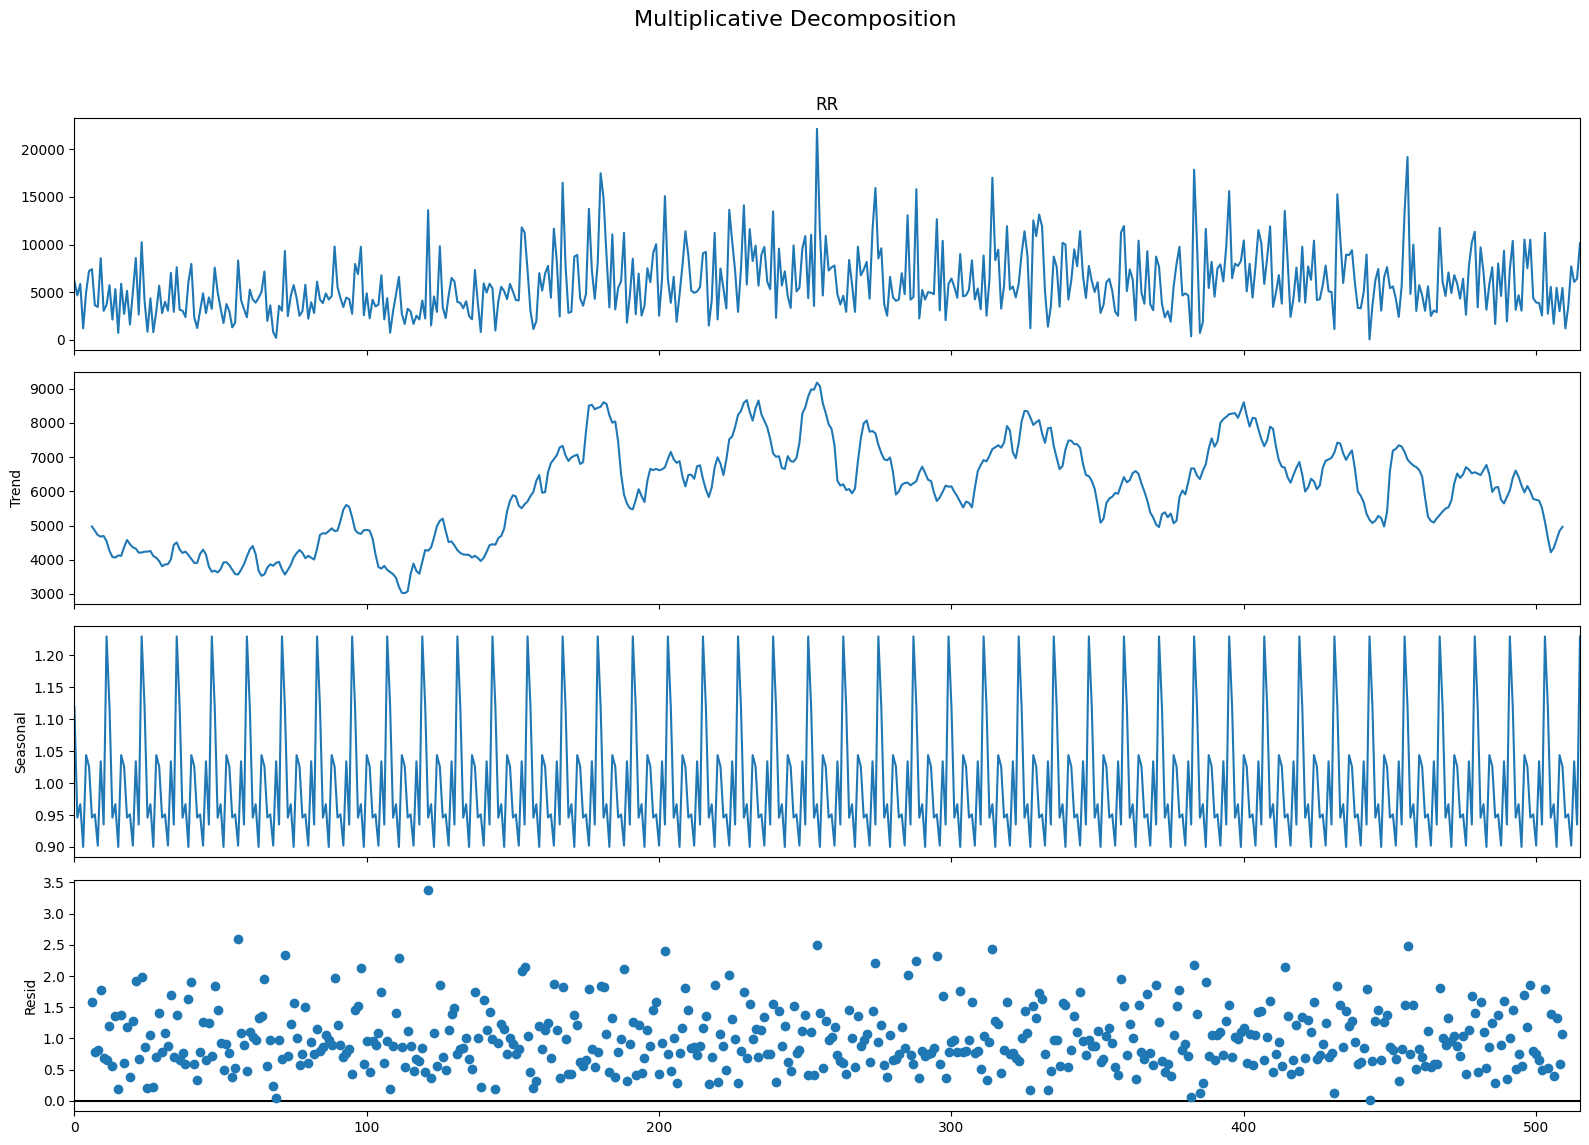

In [347]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [348]:
data_length = len(aggregated_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

In [349]:
# Préparer les séries d'apprentissage et de test
train_df = aggregated_df.iloc[:train_size]
test_df = aggregated_df.iloc[train_size:]

In [350]:
# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['RR']
X_test = test_df['RR']

In [351]:
train_size, test_size

(505, 11)

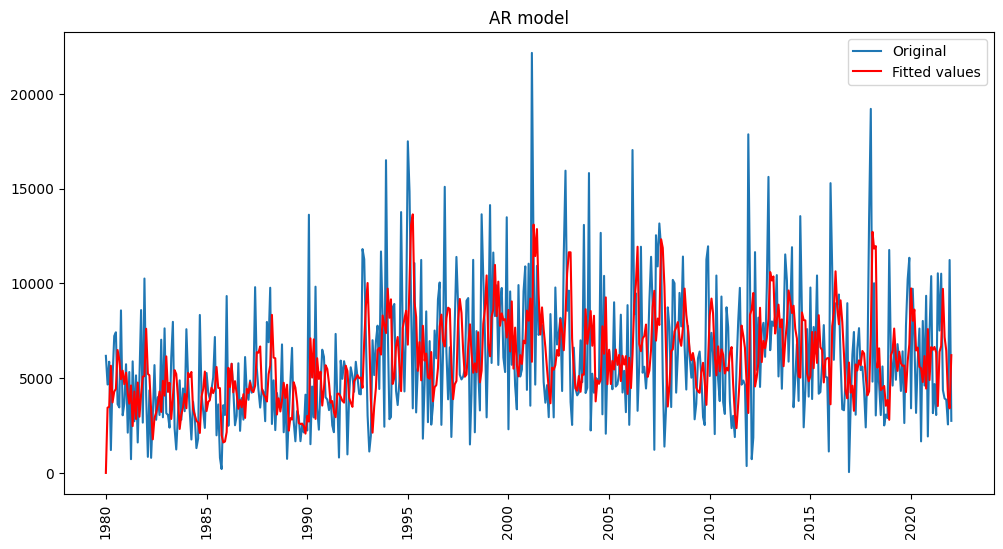

In [352]:
# Modèle ARI
model_AR = ARIMA(X_train, order=(2, 1, 0))  
results_AR = model_AR.fit()

# Préparer la visualisation pour le modèle ARI
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_AR.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

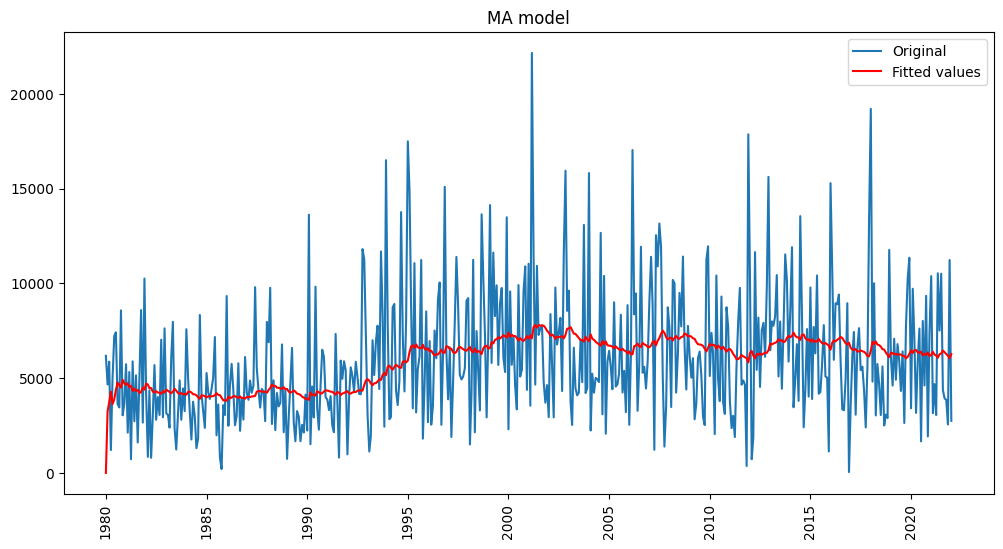

In [353]:
# Modèle MA
model_MA = ARIMA(X_train, order=(0, 1, 2))  
results_MA = model_MA.fit()

# Préparer la visualisation pour le modèle MA
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_MA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('MA model')
plt.legend()
plt.show()

c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3230.191980996108


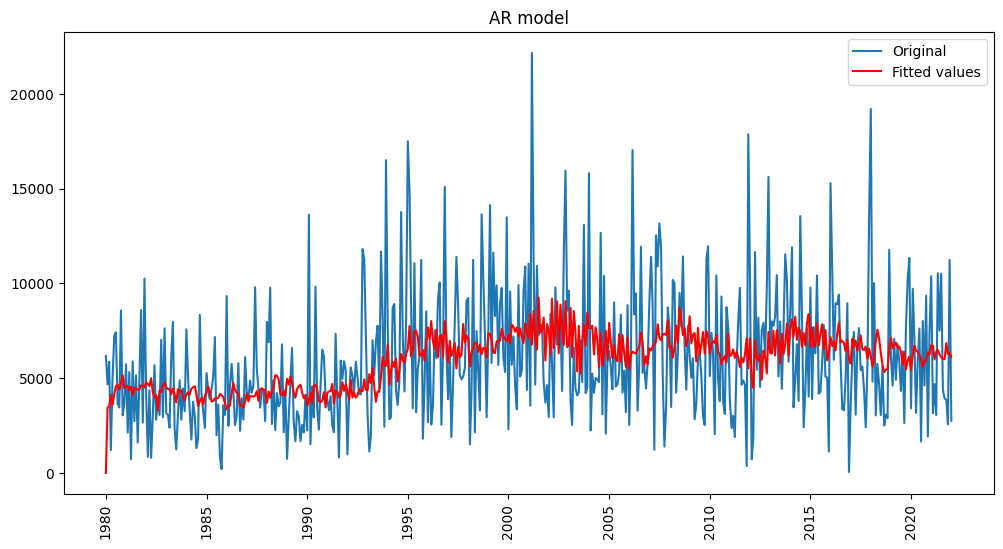

In [354]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 12))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

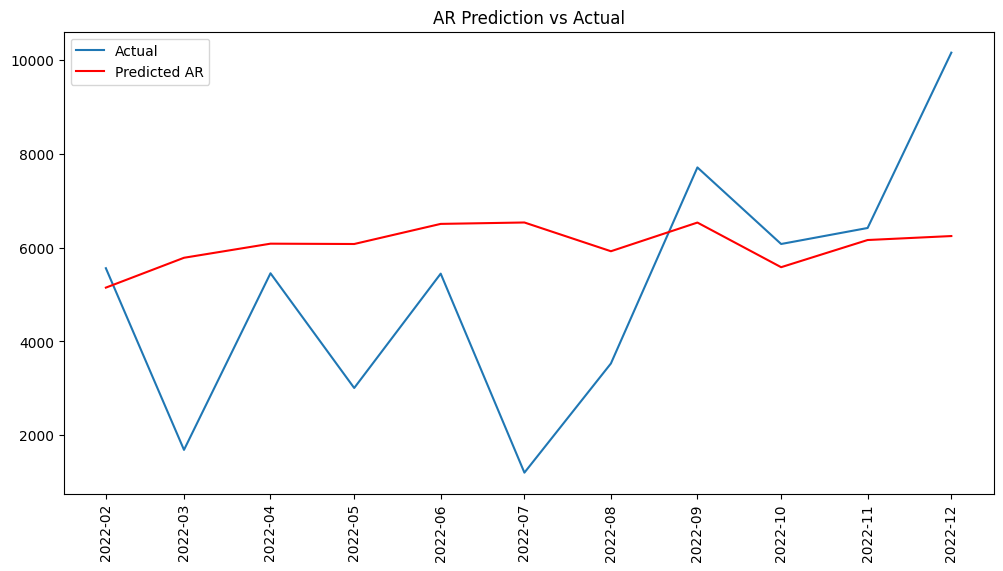

In [355]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=test_size)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], X_test, label='Actual')
plt.plot(test_df['date'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

In [358]:
X_test.shape

(11,)

In [359]:
history = [x for x in X_train]
predictions = list()


# walk-forward validation
for t in range(11):
    model = ARIMA(history, order=(12,1,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    obs = X_test.iloc[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=' + str(yhat) +', expected=' + str(obs))

c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5147.762582514757, expected=5562.1


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6037.970590656717, expected=1685.9


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6235.6630267559385, expected=5454.1


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6087.656894685122, expected=3006.1


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6694.598923328594, expected=5446.2


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6106.995037407169, expected=1200.0


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5520.146439271758, expected=3529.4


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5617.301267067089, expected=7712.3


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6176.181748753692, expected=6078.7


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5465.12065725252, expected=6420.3
predicted=5581.110557334628, expected=10161.3


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [360]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(X_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2781.566


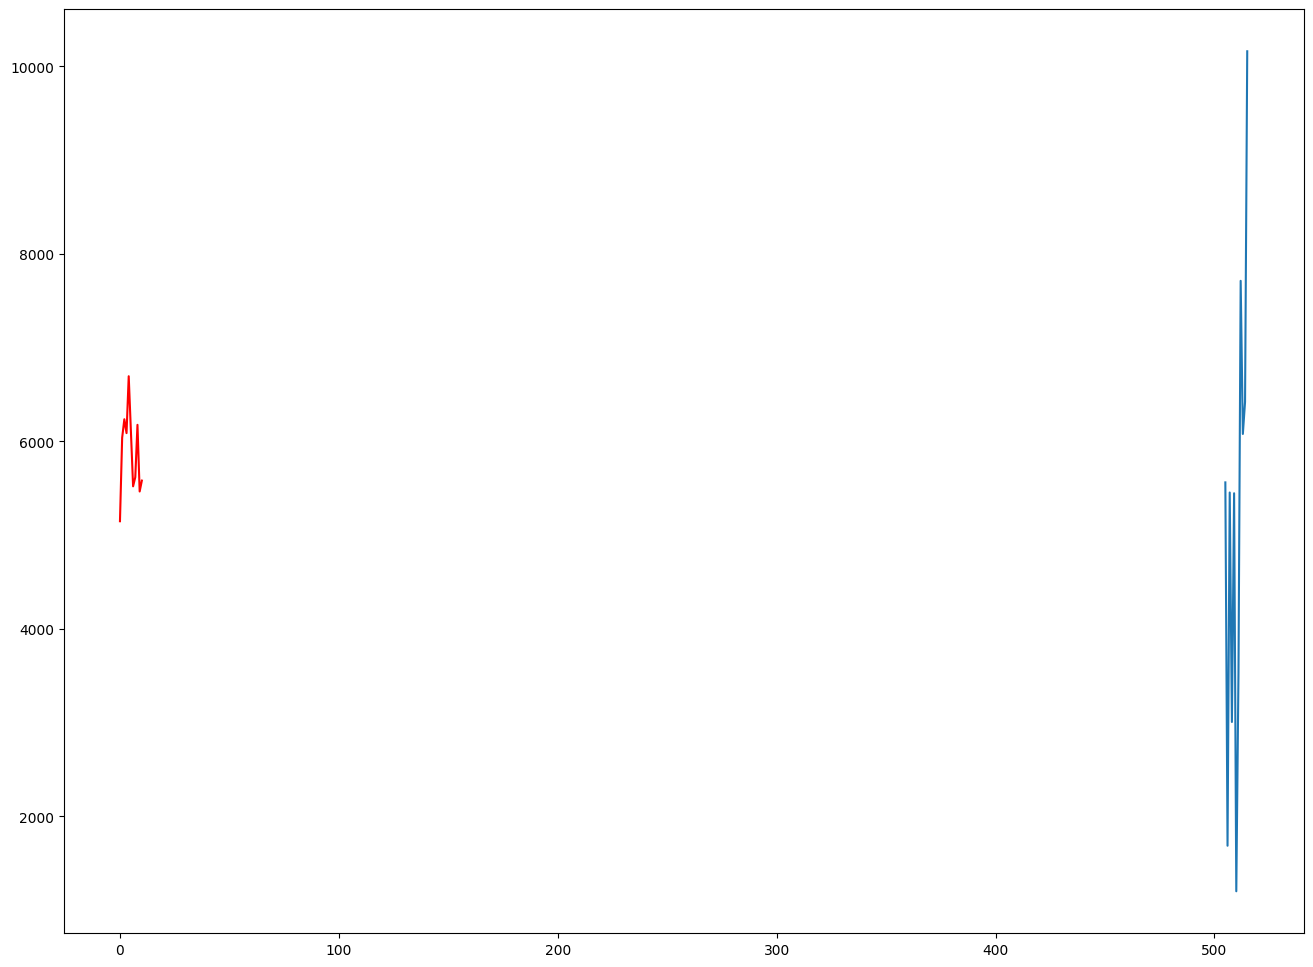

In [361]:
plt.plot(X_test)
plt.plot(predictions, color='red')
plt.show()

## Prévision Température

In [ ]:
temp_data = data.groupby("date").agg({
    'TX': 'sum',
    'TN': 'sum',
    'TM': 'sum'    
})

In [ ]:
temp_data.head(10)
#temp_data.to_csv("Temperature.csv")

,TX,TN,TM
date,,,
1980-01-01,117.7,-291.0,-86.3
1980-02-01,413.3,-94.5,159.8
1980-03-01,437.9,-59.4,189.1
1980-04-01,582.4,14.9,298.0
1980-05-01,850.0,266.9,552.0
1980-06-01,1016.2,451.2,733.4
1980-07-01,1134.0,535.8,834.7
1980-08-01,1297.3,666.8,982.4
1980-09-01,1184.8,476.5,830.7


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
temp_data_scaled = scaler.fit_transform(temp_data)

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length), :]
        y = data[i+seq_length, 0]  # Prédire TX
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 10
X, y = create_sequences(temp_data_scaled, seq_length)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
11/11 [==============================] - 5s 287ms/step - loss: 0.2132 - val_loss: 0.1515
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1132 - val_loss: 0.0689
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0662 - val_loss: 0.0673
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0645 - val_loss: 0.0590
Epoch 5/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0583 - val_loss: 0.0576
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0554 - val_loss: 0.0551
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0536 - val_loss: 0.0531
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0524 - val_loss: 0.0510
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0498 - val_loss: 0.0484
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0464 - val_loss: 0.043

4/4 [==============================] - 0s 3ms/step


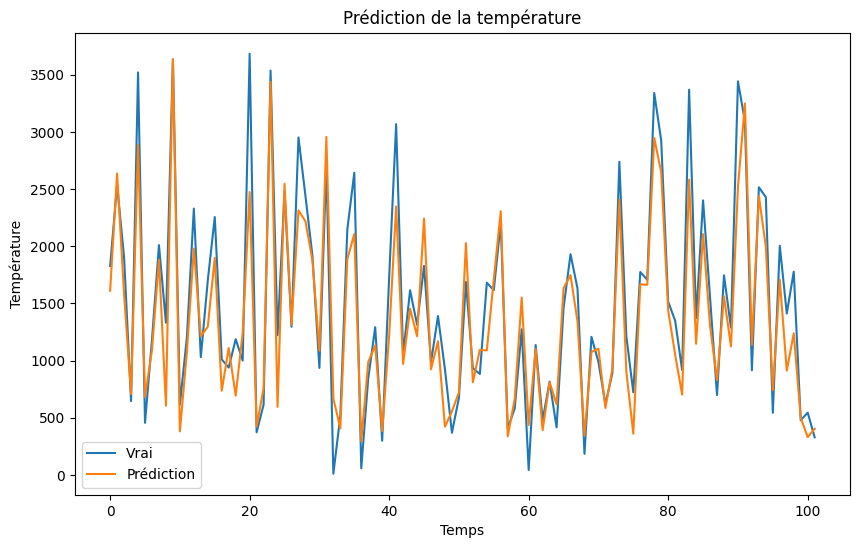

In [ ]:
# Prédiction et inversion de la normalisation pour les valeurs réelles et prédites
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test).reshape(-1, 1), np.zeros_like(y_test).reshape(-1, 1)), axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)), axis=1))[:, 0]

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Vrai')
plt.plot(y_pred_inv, label='Prédiction')
plt.title('Prédiction de la température')
plt.xlabel('Temps')
plt.ylabel('Température')
plt.legend()
plt.show()